# `Практикум по программированию на языке Python`

## `Задание 02. Сегментация изображений`

#### Фамилия, имя: Черемискин Егор

Дата выдачи: <span style="color:red">__18 марта 17:00__</span>.

Мягкий дедлайн: <span style="color:red">__01 апреля 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4.25 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2023`

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `U-Net` и `LinkNet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## `Загрузка данных (1 балл)`

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с ImageNet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [3]:
import os
import time

import numpy as np
import numpy.testing as npt

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.models import vgg13, VGG13_Weights

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

from PIL import Image, ImageEnhance

import albumentations as A
from albumentations.pytorch import ToTensorV2

import ignite
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler

In [4]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        self.images = []
        self.targets = []
        for filename in os.listdir(images_dir):
            self.images.append(Image.open(os.path.join(images_dir, filename), mode='r'))
        for filename in os.listdir(target_dir):
            self.targets.append(Image.open(os.path.join(target_dir, filename), mode='r'))
        if transforms:
            for i, (image, target) in enumerate(zip(self.images, self.targets)):
                for t in transforms:
                    try:
                        image, target = t(image, target)
                    except:
                        image = t(image)
                        try:
                            target = t(target)
                        except:
                            pass
                self.images[i] = image
                self.targets[i] = target
        
    def __len__(self):
        return len(self.images)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        if idx < self.__len__():
            return self.images[idx], self.targets[idx]
        raise IndexError


## `Модуль аугментации (2 балла)`

Конструктор стандартного `ImageFolder`, принимает параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
* случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
* случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

In [5]:
def random_decorator(p):
    def _random_decorator(f):
        def wrapper(image, mask, *args):
            if np.random.choice(2, 1, p=[1 - p, p])[0]:
                return f(image, mask, *args)
            else:
                return image, mask
        return wrapper
    return _random_decorator

In [6]:
class HorizontalFlip(object):
    def __init__(self, p=0.1):
        self.p = p
    
    def __call__(self, image, mask):
        @random_decorator(self.p)
        def f(image, mask):
            return image.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
        return f(image, mask)


In [7]:
class Crop(object):
    def __init__(self, p=0.1, size=None):
        self.p = p
        if size is None:
            self.size = (np.random.randint(100, 240, 1)[0], np.random.randint(100, 320, 1)[0])
        else:
            self.size = size
        
    def __call__(self, image, mask):
        @random_decorator(self.p)
        def f(image, mask):
            return image.crop((0, 0, self.size[0], self.size[1])).resize((240, 320)), mask.crop((0, 0, self.size[0], self.size[1])).resize((240, 320))
        return f(image, mask)

In [8]:
class ChangingBrightness(object):
    def __init__(self, p=0.1, factor=None):
        self.p = p
        if factor is None:
            self.factor = np.random.normal(1, 0.1, 1)[0]
        else:
            self.factor = factor
    
    def __call__(self, image, mask):
        @random_decorator(self.p)
        def f(image, mask, factor):
            enhancer = ImageEnhance.Brightness(image)
            return enhancer.enhance(factor), mask
        return f(image, mask, self.factor)


In [9]:
background = {}
for color in ['white', 'black', 'green', 'blue', 'purple']:
    background[color] = Image.new("RGB", (240, 320), color)
background['fire'] = Image.open('fire.jpg', mode='r')
background['city'] = Image.open('city.jpg', mode='r')
background['sky'] = Image.open('sky.jpg', mode='r')
background['water'] = Image.open('water.jpg', mode='r')
background['space'] = Image.open('space.jpg', mode='r')
background['soap'] = Image.open('soap.jpg', mode='r').resize((240, 320))

In [10]:
class ChangingBackground(object):
    def __init__(self, p=0.1, background=None):
        self.p = p
        if background is None:
            self.background = Image.open('city.jpg', mode='r')
        else:
            self.background = background
    
    def __call__(self, image, mask):
        @random_decorator(self.p)
        def f(image, mask, background):
            return Image.composite(image, background, mask), mask
        return f(image, mask, self.background)


In [11]:
my_transforms = [
    HorizontalFlip(),
    Crop(),
    ChangingBrightness(),
    ChangingBackground(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

In [12]:
DATA_PATH = ''

train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=my_transforms
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'test'),
    target_dir=os.path.join(DATA_PATH, 'test_mask'),
    transforms=my_transforms
)

Функция для отображения изображения:

In [13]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)
    
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    
    fig.tight_layout()
    plt.show()

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

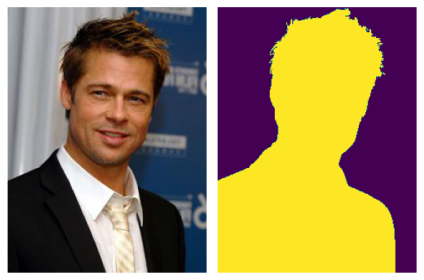

In [74]:
train_dataset_horizontalflip = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=[
        HorizontalFlip(1),
        Crop(0),
        ChangingBrightness(0),
        ChangingBackground(0),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

show_idx_image(train_dataset_horizontalflip, 780)

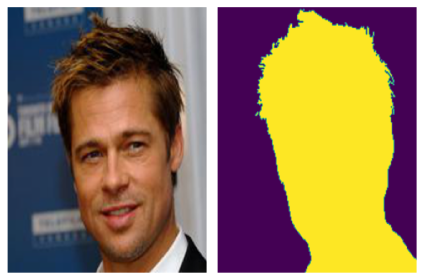

In [75]:
train_dataset_crop = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=[
        HorizontalFlip(0),
        Crop(1, (200, 200)),
        ChangingBrightness(0),
        ChangingBackground(0),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

show_idx_image(train_dataset_crop, 780)

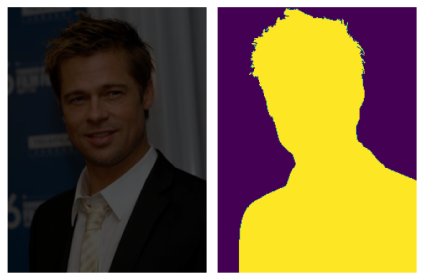

In [76]:
train_dataset_brightness = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=[
        HorizontalFlip(0),
        Crop(0),
        ChangingBrightness(1, 0.3),
        ChangingBackground(0),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

show_idx_image(train_dataset_brightness, 780)

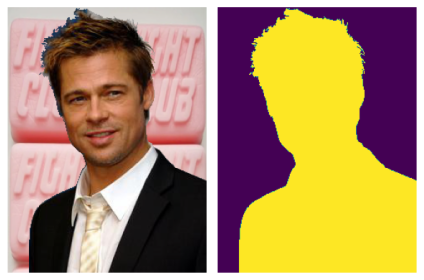

In [77]:
train_dataset_brightness = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=[
        HorizontalFlip(0),
        Crop(0),
        ChangingBrightness(0),
        ChangingBackground(1, background['soap']),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

show_idx_image(train_dataset_brightness, 780)

## `Загрузчики`

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и так далее) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

Обычно, скорость обработки данных на GPU превышает скорость загрузки данных в одном процессе, поэтому типичное значение для `num_workers`$\approx 3\text{-}10$. 

Учтите, что на некоторых системах в Jupyter Notebook при `num_workers`$>0$ `DataLoader` перестаёт работать. В таком случае установите это значение в $0$.

In [14]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=0)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=0, shuffle=True)

## `DiceLoss (1 балл)`

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через `torch.nn.Module`. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат **Dice Loss** определим как:

$$
\text{Dice Coefficient} = 2\frac{|A \cap B| }{|A| + |B|} \leadsto \text{Dice Loss} = 1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — истинная разметка для пикселя изображения.

In [15]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.to(torch.long)
        if self.with_logits:
            logits = torch.sigmoid(logits)
            
        loss_value = 1 - torch.div(2 * torch.sum(torch.mul(logits, true_labels), tuple(range(1, len(logits.shape)))), torch.sum(torch.add(logits, true_labels), tuple(range(1, len(logits.shape)))) + self.eps)
        if self.reduction == 'sum':
            loss_value = torch.sum(loss_value) 
        elif self.reduction == 'mean':
            loss_value = torch.mean(loss_value) 
            
        return loss_value

Проверка реализации:

In [16]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## `U-Net (3 балла)`

Для решения задачи сегментации будем использовать [U-Net](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`.

Концептуальная схема представлена на диаграмме ниже:

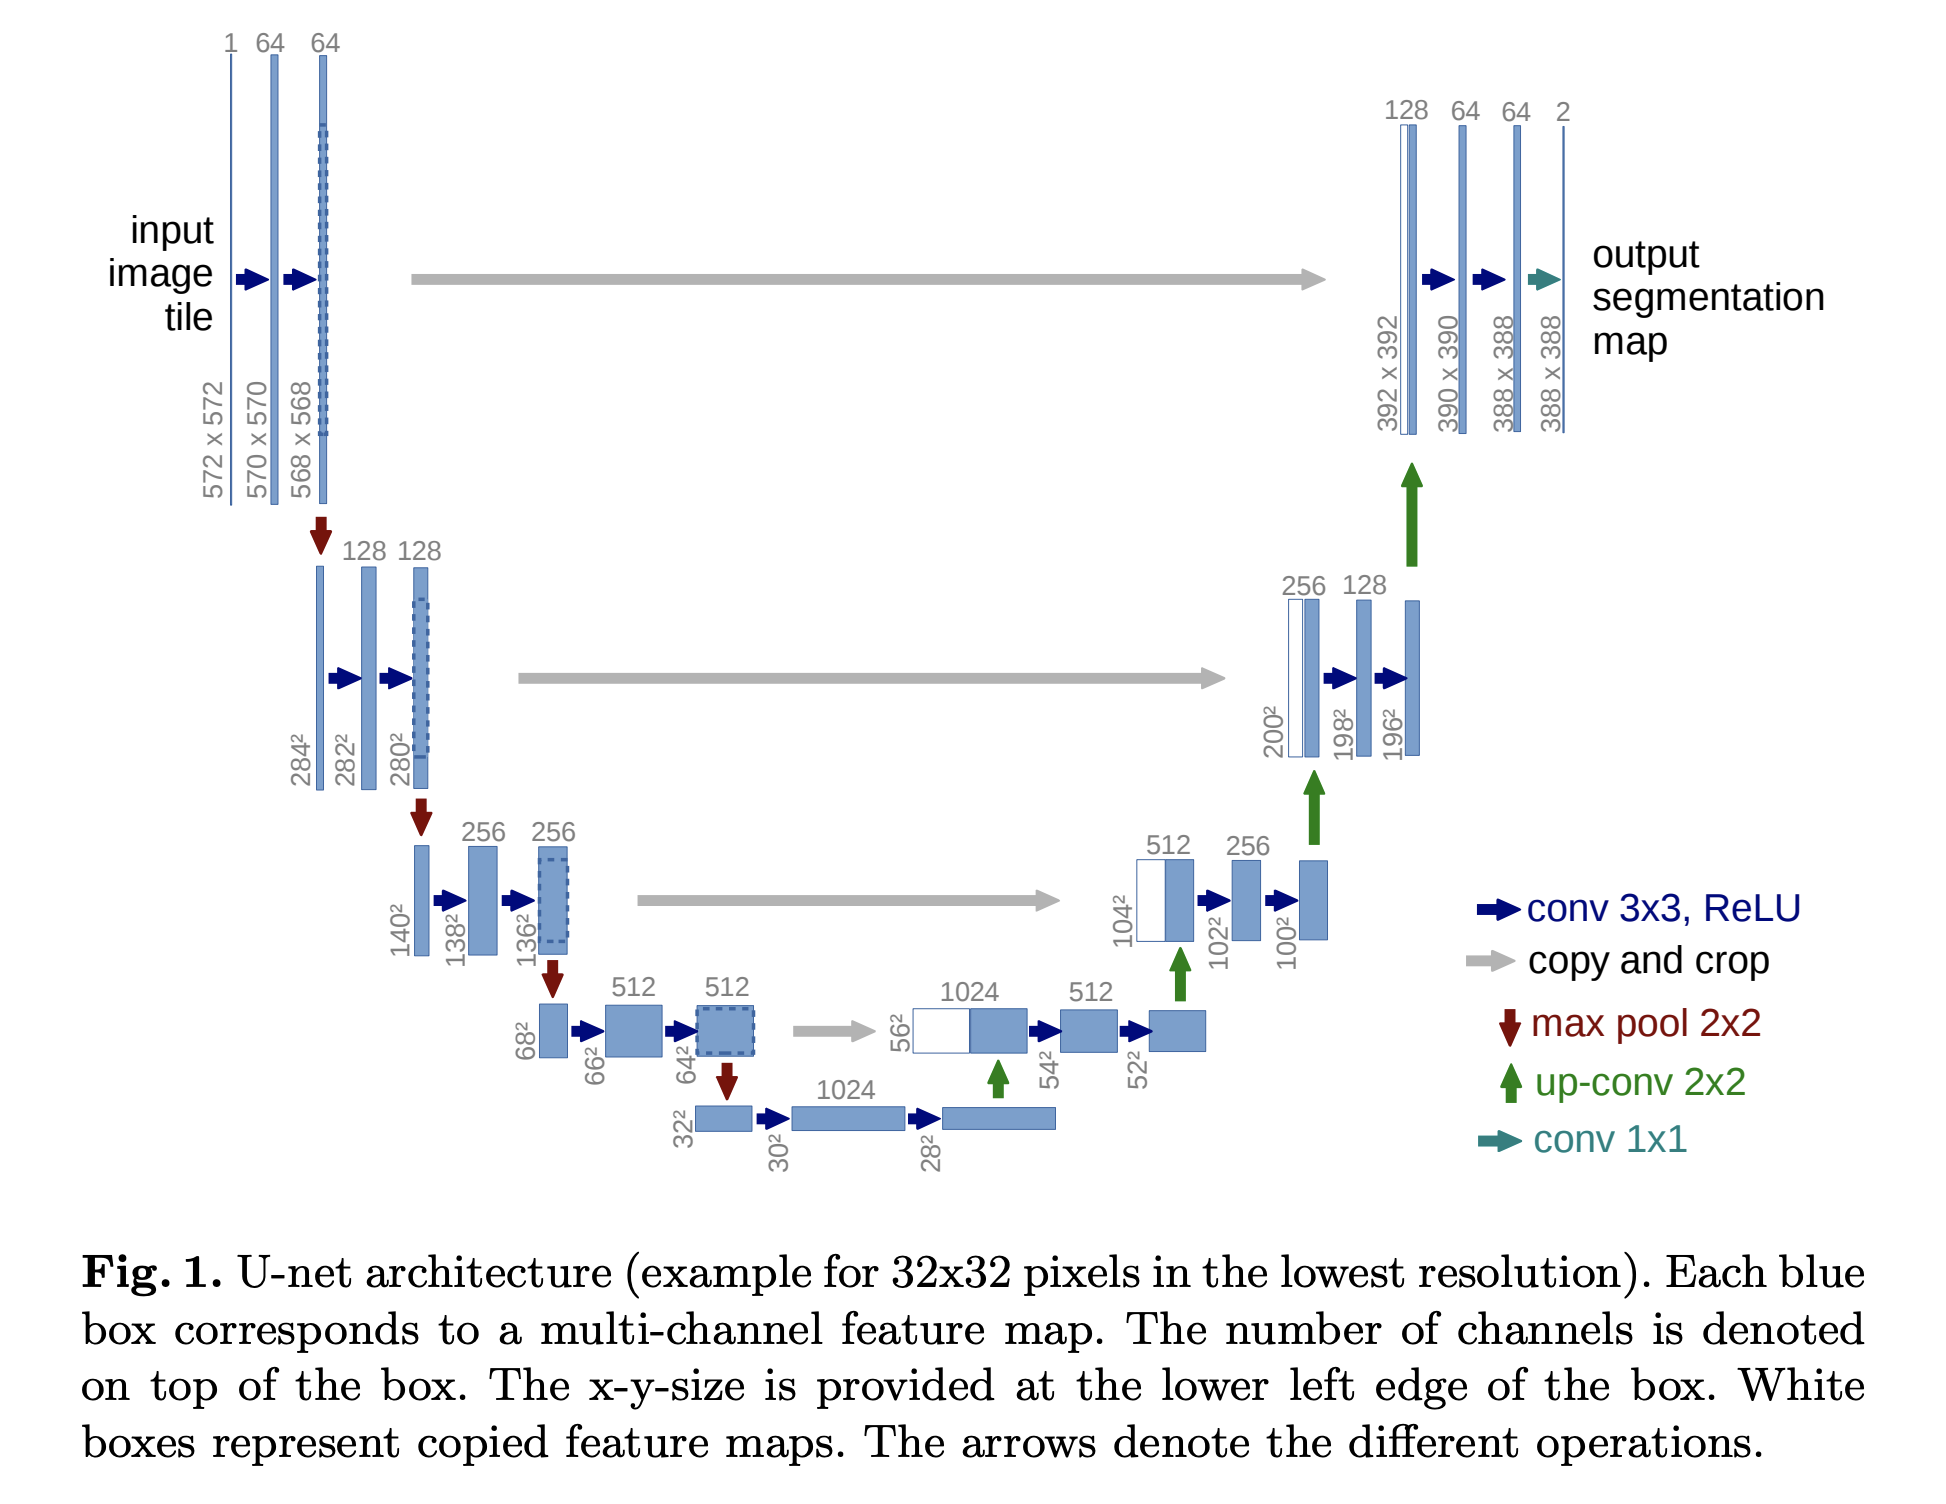

Заметим, что блоки VGG13 имеют следующий вид:
```python
    (0): Conv2d(...)
    (1): ReLU(...)
    (2): Conv2d(...)
    (3): ReLU(...)
    (4): MaxPool2d(...)
```

Для удобства, уберём слои `MaxPool2d` из блоков энкодера и будем применять pooling отдельно.

Реализуйте архитектуру данной сети.

#### `Encoder`

In [17]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks
        
        # Будем использовать предобученную VGG13 в качестве backbone
        feature_extractor = vgg13(weights=weights).features
        
        # Каждый блок энкодера U-Net — это блок VGG13 без MaxPool2d
        self.blocks = torch.nn.ModuleList()
        for idx in range(self.num_blocks):
            # Возьмите нужные слои из `feature_extractor` для очередного U-Net блока
            # Объедините их с помощью `torch.nn.Sequential`
            self.blocks.append(
                torch.nn.Sequential(
                    feature_extractor[5 * idx], 
                    feature_extractor[5 * idx + 1], 
                    feature_extractor[5 * idx + 2], 
                    feature_extractor[5 * idx + 3], 
                )
            )

    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            # Примените очередной блок U-Net
            x = block(x)

            # Сохраните активации для передачи их в декодер
            activations.append(x)

            # При необходимости примените max-pool
            # Можно использовать `torch.functional.F.max_pool2d`
            if idx != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
            
        return activations

In [18]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

#### `Decoder`

In [19]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()
        
    def forward(self, down, left):
        # Upsample x2 и свёртка
        x = torch.nn.Upsample(scale_factor=2)(self.upconv(down))
        
        # Конкатенация выхода энкодера и предыдущего блока декодера
        x = torch.cat((left, x), 1)
        
        # Две свёртки с ReLu
        x = self.relu(self.conv2(self.relu(self.conv1(x))))

        return x

In [20]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

#### `U-Net`

In [21]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks)
        
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks-1)
        
        # Свёртка 1x1 для попиксельной агрегации каналов
        self.final = torch.nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.final(x)
        return x

In [22]:
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0): DecoderBlock(
        (upconv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

### `Оценивание качества сети`


Обычно, оптимизируемый функционал сложно интерпретировать, а так же в разных экспериментах могут использоваться разные функции потерь. Поэтому необходимо замерять и отслеживать независимую метрику качества. Предлагается использовать **IoU (Intersection over Union)** — один из стандартных вариантов для задачи сегментации:
$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

In [23]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.threshold = threshold
        self.reduction = reduction
        
    @torch.no_grad()
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        logits = torch.where(logits > self.threshold, 1, 0)
        sum_mul = torch.sum(torch.mul(logits, true_labels), tuple(range(1, len(logits.shape))))
        score = torch.div(sum_mul, torch.sum(logits, tuple(range(1, len(logits.shape)))) + torch.sum(true_labels, tuple(range(1, len(logits.shape)))) - sum_mul)
        
        if self.reduction == 'sum':
            score = torch.sum(score)
        elif self.reduction == 'mean':
            score = torch.mean(score) 
            
        return score

In [24]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

### `Tensorboard и логирование`

Для отслеживания процесса обучения обычно требуется сохранять информацию разных его аспектах.

Для полного контроля над процессом обучения обычно требуется сохранять информацию о разных статистиках. Самыми очевидными являются:
1. Значение функции потерь (лосса) на обучающей и тестовой выборках
2. Метики качества, например, **Dice Coefficient** и **IoU (Intersection over Union)** на обучающей и тестовой выборках

Однако, суррогатные метрики могут не отражать реального качества. Поэтому для моделей, которые выдают визуализируемый результат, обычно логируют предсказания для некоторых объектов выборки. В задаче сегментации естественным вариантом является логирование четвёрки: исходное изображение, истинная маска, маска вероятностей истинного класса, бинаризованная маска. 

*Замечание:* лосс и качество на обучающей выборке обычно логируют не только в конце каждой эпохи, но и по отдельным батчам на каждой итерации.

3. Чтобы отслеживать динамику обучения необходимо зафиксировать небольшой набор объектов обучающей и тестовой выборок и после каждой эпохи обучения логировать указанные четыре картинки для каждого объекта.

*Замечание:* можно логировать четвёрки изображений независимо, однако, удобнее объединить их на одной [фигуре](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure). Дополнительный плюс — возможность подписать значения метрик для этого объекта в заголовке изображения или добавить colorbar для более простой интерпретации предсказанной маски.

Для удобной категоризации экспериментов обычно в начале обучения сохраняют:

4. [Гиперпараметры модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams) 
5. [Структуру модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph)

Для исследования технических особенностей обучения полезно логировать следующие статистики:

6. [Распределение весов, активаций, градиентов](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram). Сохранять гистограммы каждого параметра после каждой итерации может быть вычислительно неэффективно, поэтому обычно сохраняют распределения весов для каждого отдельного слоя нейронной сети после каждой эпохи. 
7. Норма весов и норма градиента на каждой итерации

Наконец, после каждой эпохи можно визуализировать промежуточные представления входных данных:

8. Активации после каждого слоя/блока, как изображения
9. Градиенты функции потерь по активациям для некоторых объектов обучающей выборки, как изображения

*Замечание:* для реализации пунктов 8, 9 менять код модели не требуется. Используйте хуки: [register_full_backward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook), [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook).

При реализации цикла обучения необходимо сохранять метрики $1\text{-}9$ с использованием модуля [torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html). Файлы с логами, а также чекпоинты весов модели после итерации с наилучшим валидационным качеством (смотрите [torch.save](https://pytorch.org/docs/stable/generated/torch.save.html) и [torch.nn.Module.state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)) для **ВСЕХ** проведённых экспериментов (за исключением упавших, недосчитанных и так далее) необходимо сдать в anytask.

### `Эксперименты`

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации:
1. Только кросс-энтропия
2. Только dice loss
3. Сумма двух лоссов с весами (попробуйте $3\text{-} 4$ разных соотношения)

**Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.**

In [25]:
def val(model, criterion, device, data_loader):
    model = model.eval()
    loss = 0.
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            total += inputs.size(0)
            outputs = model(inputs)
            loss += float(criterion(outputs, labels).detach())
    return loss / total

In [26]:
def write_norms(model, writer, epoch, idx):
    norm_weights = 0.
    norm_grads = 0.
    for i in range(4):
        for j in range(2):
            norm_weights += torch.norm(model.encoder.blocks[i][2 * j].weight)
    for i in range(3):
        norm_weights += torch.norm(model.decoder.blocks[i].upconv.weight)
        norm_weights += torch.norm(model.decoder.blocks[i].conv1.weight)
        norm_weights += torch.norm(model.decoder.blocks[i].conv2.weight)
    norm_weights += torch.norm(model.final.weight)
    for i in range(4):
        for j in range(2):
            norm_grads += torch.norm(model.encoder.blocks[i][2 * j].weight.grad)
    for i in range(3):
        norm_grads += torch.norm(model.decoder.blocks[i].upconv.weight.grad)
        norm_grads += torch.norm(model.decoder.blocks[i].conv1.weight.grad)
        norm_grads += torch.norm(model.decoder.blocks[i].conv2.weight.grad)
    norm_grads += torch.norm(model.final.weight.grad)
    writer.add_scalar('Norm of weights for ' + str(epoch) + ' epoch/', norm_weights, idx)
    writer.flush()
    writer.add_scalar('Norm of grads for ' + str(epoch) + ' epoch/', norm_grads, idx)
    writer.flush()
    return

def write_weights(model, writer, epoch):
    for i in range(4):
        for j in range(2):
            writer.add_histogram('Weights of encoder in ' + str(epoch) + ' epoch/' + str(j) + ' layer in ' + str(i) + ' block', model.encoder.blocks[i][2 * j].weight)
            writer.flush()
    for i in range(3):
        writer.add_histogram('Weights of decoder in ' + str(epoch) + ' epoch/' + 'upconv' + ' layer in ' + str(i) + ' block', model.decoder.blocks[i].upconv.weight)
        writer.flush()
        writer.add_histogram('Weights of decoder in ' + str(epoch) + ' epoch/' + 'conv1' + ' layer in ' + str(i) + ' block', model.decoder.blocks[i].conv1.weight)
        writer.flush()
        writer.add_histogram('Weights of decoder in ' + str(epoch) + ' epoch/' + 'conv2' + ' layer in ' + str(i) + ' block', model.decoder.blocks[i].conv2.weight)
        writer.flush()
    writer.add_histogram('Weights of final layer in ' + str(epoch) + ' epoch', model.final.weight)
    writer.flush()
    return
    
def write_grads(model, writer, epoch):
    for i in range(4):
        for j in range(2):
            writer.add_histogram('Grads of encoder in ' + str(epoch) + ' epoch/' + str(j) + ' layer in ' + str(i) + ' block', model.encoder.blocks[i][2 * j].weight.grad)
            writer.flush()
    for i in range(3):
        writer.add_histogram('Grads of decoder in ' + str(epoch) + ' epoch/' + 'upconv' + ' layer in ' + str(i) + ' block', model.decoder.blocks[i].upconv.weight.grad)
        writer.flush()
        writer.add_histogram('Grads of decoder in ' + str(epoch) + ' epoch/' + 'conv1' + ' layer in ' + str(i) + ' block', model.decoder.blocks[i].conv1.weight.grad)
        writer.flush()
        writer.add_histogram('Grads of decoder in ' + str(epoch) + ' epoch/' + 'conv2' + ' layer in ' + str(i) + ' block', model.decoder.blocks[i].conv2.weight.grad)
        writer.flush()
    writer.add_histogram('Grads of final layer in ' + str(epoch) + ' epoch', model.final.weight.grad)
    writer.flush()
    return

def write_activations(model, writer, activation, epoch):
    for i in range(4):
        for j in range(2):
            writer.add_histogram('Activations of encoder in ' + str(epoch) + ' epoch/' + str(j) + ' layer in ' + str(i) + ' block', activation[str(j) + ' layer in ' + str(i) + ' block of encoder'])
            writer.flush()
    for i in range(3):
        writer.add_histogram('Activations of decoder in ' + str(epoch) + ' epoch/' + 'upconv' + ' layer in ' + str(i) + ' block', activation['upconv layer in ' + str(i) + ' block of decoder'])
        writer.flush()
        writer.add_histogram('Activations of decoder in ' + str(epoch) + ' epoch/' + 'conv1' + ' layer in ' + str(i) + ' block', activation['conv1 layer in ' + str(i) + ' block of decoder'])
        writer.flush()
        writer.add_histogram('Activations of decoder in ' + str(epoch) + ' epoch/' + 'conv2' + ' layer in ' + str(i) + ' block', activation['conv2 layer in ' + str(i) + ' block of decoder'])
        writer.flush()
    return

def write_image(model, writer, device, dataset, name_dataset, idx, epoch):
    image, mask = dataset[idx]
    output = model(image[None, :, :, :].to(device)).cpu()
    output_mask = torch.where(output >= 0, 255, 0)

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)
    mask = mask.squeeze(0).numpy()
    output = output.detach().squeeze().numpy()
    output_mask = output_mask.squeeze().numpy()

    fig, axes = plt.subplots(2, 2, figsize=(6, 4))

    axes[0][0].imshow(image)
    axes[0][1].imshow(mask)
    axes[1][0].imshow(output)
    axes[1][1].imshow(output_mask)
    
    axes[0][0].set_axis_off()
    axes[0][1].set_axis_off()
    axes[1][0].set_axis_off()
    axes[1][1].set_axis_off()
    
    fig.tight_layout()
    writer.add_figure(name_dataset + " figure for " + str(epoch) + " epoch", fig)
    return

def image_activations(model, activation):
    activation = activation[0][0].squeeze().detach().cpu().numpy()
    activation = np.clip(activation, 0, 1)
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    axes.imshow(activation)
    axes.set_axis_off()
    fig.tight_layout()
    return fig
    
def write_image_activations(model, writer, activation, epoch):
    for i in range(4):
        for j in range(2):
            image = image_activations(model, activation[str(j) + ' layer in ' + str(i) + ' block of encoder'])
            writer.add_figure('Image of activation of encoder in ' + str(epoch) + ' epoch/' + str(j) + ' layer in ' + str(i) + ' block', image)
            writer.flush()
    for i in range(3):
        image = image_activations(model, activation['upconv layer in ' + str(i) + ' block of decoder'])
        writer.add_figure('Image of activation of decoder in ' + str(epoch) + ' epoch/' + 'upconv' + ' layer in ' + str(i) + ' block', image)
        writer.flush()
        image = image_activations(model, activation['conv1 layer in ' + str(i) + ' block of decoder'])
        writer.add_figure('Image of activation of decoder in ' + str(epoch) + ' epoch/' + 'conv1' + ' layer in ' + str(i) + ' block', image)
        writer.flush()
        image = image_activations(model, activation['conv2 layer in ' + str(i) + ' block of decoder'])
        writer.add_figure('Image of activation of decoder in ' + str(epoch) + ' epoch/' + 'conv2' + ' layer in ' + str(i) + ' block', image)
        writer.flush()
    return

activation = {}
def getActivation(name):
    def hook(model, inputs, outputs):
        activation[name] = outputs.detach()
    return hook

In [27]:
def train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, name_weights, write_activations_flag, write_norms_flag, write_weights_flag, write_grads_flag, write_image_flag, write_image_activations_flag):
    model = model.to(device)
    writer = SummaryWriter()
    writer.add_graph(model, train_dataset[780][0].clone()[None, :, :, :].to(device))
    min_loss = 1e5

    if write_activations_flag or write_image_activations_flag:
        hook_encoder = [[0] * 2 for i in range(4)]
        hook_decoder = [[0] * 3 for i in range(3)]
        for i in range(4):
            for j in range(2):
                hook_encoder[i][j] = model.encoder.blocks[i][2 * j].register_forward_hook(getActivation(str(j) + ' layer in ' + str(i) + ' block of encoder'))
        for i in range(3):
            hook_decoder[i][0] = model.decoder.blocks[i].upconv.register_forward_hook(getActivation('upconv layer in ' + str(i) + ' block of decoder'))
            hook_decoder[i][1] = model.decoder.blocks[i].conv1.register_forward_hook(getActivation('conv1 layer in ' + str(i) + ' block of decoder'))
            hook_decoder[i][2] = model.decoder.blocks[i].conv2.register_forward_hook(getActivation('conv2 layer in ' + str(i) + ' block of decoder'))

    for epoch in range(num_epoch):
        model.train()
        loss_train = 0.
        iou_train = 0.
        dice_train = 0.
        total = 0
        for idx, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(inputs)
        
            loss = criterion(outputs, labels)
            iou = iou_score(outputs, labels)
            dice = dice_score(outputs, labels)
            loss_train += loss * inputs.size(0)
            iou_train += iou * inputs.size(0)
            dice_train += dice * inputs.size(0)
            total += inputs.size(0)
            
            if loss < min_loss:
                min_loss = loss
                torch.save(model.state_dict(), name_weights)
        
            writer.add_scalar("Train/Loss for " + str(epoch) + " epoch", loss, idx)
            writer.add_scalar("Train/IoU for " + str(epoch) + " epoch", iou, idx)
            writer.add_scalar("Train/Dice for " + str(epoch) + " epoch", dice, idx)
            writer.flush()
        
            loss.backward()
            optimizer.step()
        
            if write_norms_flag:
                write_norms(model, writer, epoch, idx)
    
        writer.add_scalar("Train/Loss for epochs", loss_train / total, epoch)
        writer.add_scalar("Train/IoU for epochs", iou_train / total, epoch)
        writer.add_scalar("Train/Dice for epochs", dice_train / total, epoch)
        writer.flush()
    
        iou_test = val(model, iou_score, device, test_data_loader)
        writer.add_scalar("Test/IoU", iou_test, epoch)
        dice_test = val(model, dice_score, device, test_data_loader)
        writer.add_scalar("Test/Dice", dice_test, epoch)
        loss_test = val(model, criterion, device, test_data_loader)
        writer.add_scalar("Test/Loss", loss_test, epoch)
        writer.flush()
        
        if write_activations_flag:
                write_activations(model, writer, activation, epoch)
                
        if write_image_activations_flag:
                write_image_activations(model, writer, activation, epoch)
    
        if write_weights_flag:
            write_weights(model, writer, epoch)
    
        if write_grads_flag:
            write_grads(model, writer, epoch)
        
        if write_image_flag:
            write_image(model, writer, device, train_dataset, 'Train', 780, epoch)
            write_image(model, writer, device, test_dataset, 'Test', 22, epoch)


    writer.add_hparams({'lr': lr, 'num_epoch': num_epoch, 'weight_decay': weight_decay}, {'Loss for test': val(model, criterion, device, test_data_loader)})
    writer.close()

Только кросс-энтропия

In [27]:
num_epoch = 20
lr = 1e-4
weight_decay = 1e-4

model = UNet(num_classes=1, num_blocks=4)

criterion = torch.nn.BCEWithLogitsLoss()
iou_score = IoUScore(0, reduction='mean')
dice_score = DiceLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, 'weights_cross', True, True, True, True, True, True)

Только DiceLoss

In [36]:
activation = {}
criterion = DiceLoss(reduction='mean')
train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, 'weights_dice', True, True, True, True, True, True)

Сумма кросс-энтропии и Diceloss'а

In [37]:
class SumLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction='mean', with_logits=True, a=1, b=1):
        super().__init__()
        self.DiceLoss = DiceLoss(eps=eps, reduction=reduction, with_logits=with_logits)
        self.BCEWithLogitsLoss = torch.nn.BCEWithLogitsLoss()
        self.a = a
        self.b = b

    def forward(self, logits, true_labels):
        return self.a * self.DiceLoss.forward(logits, true_labels) + self.b * self.BCEWithLogitsLoss.forward(logits, true_labels)

In [38]:
activation = {}
critetion = SumLoss()
train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, 'weights_sum', True, True, True, True, True, True)

Сумма кросс-энтропии, умноженной на 5, и DiceLoss'а

In [39]:
activation = {}
critetion = SumLoss(a=5)
train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, 'weights_5cross', True, True, True, True, True, True)

Сумма кросс-энтропии и DiceLoss'а, умноженного на 5

In [40]:
activation = {}
critetion = SumLoss(b=5)
train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, 'weights_5dice', True, True, True, True, True, True)

In [70]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs --port=12

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Выводы:

1) Среди пяти стратегий оптимизации (только кросс-энтропия, только DiceLoss, сумма кросс-энтропии и DiceLoss'а, такая же взвешенная сумма, но кросс-энтропия умножена на 5, такая же взвешенная сумма, но DiceLoss умножен на 5) существенно хуже остальных оказалась кросс-энтропия (значение лосса на тесте 0.026 после 20 эпох), остальные стратегии оптимизации показали примерно одинаковый результат (значение лосса на тесте около 0.006 после 20 эпох). Однако если сравнивать стратегии по значению метрик DiceLoss и IoU-score на тесте после 20 эпох, то все стратегии показали примерно одинаковый результат (0.006 DiceLoss и 0.11 IoU-score)

2) Зачастую графики функции потерь и функции качества не являются монотонными и совершают скачки. Особенно сильно это видно для графика суммы двух лоссов. 

3) Если посмотреть на зафиксированное изображение для тестовой и обучающей выборок, то действительно можно заметить, что с увеличением числа эпох нейронная сеть более корректно сегментирует изображение. Особенно это видно по изображению тестовой выборки, посколько его маска является достаточно нестандартной для датасета

4) С увеличением эпохи нормы весов и градиентов уменьшаются 


## `LinkNet (2 балла)`

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

**Обучите сеть и проведите анализ согласно предыдущему пункту. Сравните LinkNet и U-Net по качеству и скорости работы. Сделайте выводы.**

In [28]:
class LinkNetDecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()
        
    def forward(self, down, left):
        x = torch.nn.Upsample(scale_factor=2)(self.upconv(down))
        x = x + left
        x = self.relu(self.conv2(self.relu(self.conv1(x))))
        return x

In [29]:
class LinkNetDecoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, LinkNetDecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

In [30]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks)
        self.decoder = LinkNetDecoder(num_filters=64, num_blocks=num_blocks-1)
        self.final = torch.nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.final(x)
        return x

Только кросс-энтропия

In [60]:
model = LinkNet(num_classes=1, num_blocks=4)

activation = {}
criterion = torch.nn.BCEWithLogitsLoss()
iou_score = IoUScore(0, reduction='mean')
dice_score = DiceLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, 'linknet_weights_cross', True, True, True, True, True, True)

Только DiceLoss

In [61]:
activation = {}
criterion = DiceLoss(reduction='mean')
train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, 'linknet_weights_dice', True, True, True, True, True, True)

Сумма кросс-энтропии и Diceloss'а

In [62]:
activation = {}
critetion = SumLoss()
train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, 'linknet_weights_sum', True, True, True, True, True, True)

Сумма кросс-энтропии, умноженной на 5, и DiceLoss'а

In [63]:
activation = {}
critetion = SumLoss(a=5)
train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, 'linknet_weights_5cross', True, True, True, True, True, True)

Сумма кросс-энтропии и DiceLoss'а, умноженного на 5

In [64]:
activation = {}
critetion = SumLoss(b=5)
train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, 'linknet_weights_5dice', True, True, True, True, True, True)

In [66]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs --port=6008

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [72]:
t = time.time()
num_epoch = 1
model = UNet(num_classes=1, num_blocks=4)
criterion = torch.nn.BCEWithLogitsLoss()
train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, 'linknet_weights_5dice', True, True, True, True, True, True)
print('U-Net: ', time.time() - t)

t = time.time()
num_epoch = 1
model = LinkNet(num_classes=1, num_blocks=4)
criterion = torch.nn.BCEWithLogitsLoss()
train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, 'linknet_weights_5dice', True, True, True, True, True, True)
print('LinkNet: ', time.time() - t)

U-Net:  79.56150531768799
LinkNet:  61.756855964660645


Выводы:

1) Как и для предыдущей нейронной сети, кросс-энтропия показала наихудший результат (лосс на тесте после 20 эопх 0.0278). DiceLoss достиг значения лосса на тесте 0.0067 после 20 эпох, остальные стратегии оптимизации показали значение лосса на тесте около 0.006 после 20 эпох, а самой эффективной стратегией оказала сумма кросс-энтропии и DiceLoss, где DiceLoss умножен на 5

2) Заметим, что U-Net и LinkNet показали примерно одинаковые результаты для разных метрик и для разных стратегий оптимизации, но U-Net показал чуть лучшие результаты, чем LinkNet

3) Одна эпоха для U-Net обучается на 18 секунд дольше, чем для LinkNet, обусловлено это тем, что в декодере для U-Net в два раза больше каналов, так как он конкатенирует результаты прошлого слоя и слоя из энкодера, в то время как LinkNet их просто складывает

## `Теоретические вопросы (1 балл)`

### `Вопрос 1`
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

1) Пиксели не являются независимыми, и близкие к друг другу пиксели содержат похожую информацию (некий аналог гипотезы компактности)
2) Если данные гипотезы выполняются, то сверточный слой собирает информацию о группе соседних (или близких к друг другу) пикселей, тем самым сверточному слою удается найти узоры/предметы на изображении или некоторую закономерность в данных исходя не из одного отдельного пикселя, а их совокупности
3) Например, если взять картинку и перемешать все пиксели. Тогда сверточная сеть не сможет показать приемлимый результат. В то же время, если бы мы обучали другой алгоритм машинного обучения и рассматривали пиксели как отдельные признаки изображения, то перемешивание пикселей изображения не повлияло бы на результат

### `Вопрос 2`
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

Для $f$:

1) Размерность выходного пространства будет $1000 \times 1$ по правилам матричного умножения

2) Так как обучаемыми параметрами являются элементы матрицы весов, то всего будет $10^5$ обучаемых параметров

3) Для одного элемента выходного вектора требуется произвести $100$ умножений, $99$ сложений и одну операцию активации. Тем самым суммарно потребуется произвести $2 * 10^5$ операций

Для $g$:

1) Так как на вход подается одномерный вектор, а свертка производится с ядром размером $3$ и паддингом $1$, при этом свертка имеет $10$ выходных каналов, то выходная матрица будет иметь размерность  $10 \times 100$

2) Так как у свертки $10$ одномерных ядер размером $3$, то всего будет $30$ обучаемых параметров

3) Для каждого элемента выходной матрицы необходимо произвести $3$ умножения и $2$ сложения, тогда суммарно потребуется $5000$ операций

## `Бонус: постобработка изображений (1 балл)`

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## `Бонус: существенное улучшение качества (2 балла)`

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## `Бонус: обучение с использованием сторонних фреймворков (1 балл)`

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).

In [61]:
num_epoch = 20
lr = 1e-4
weight_decay = 1e-4

model = UNet(num_classes=1, num_blocks=4)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [62]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, metrics={"cross-entropy": Loss(torch.nn.BCEWithLogitsLoss()), "dice": Loss(DiceLoss(reduction='mean')), "iou": Loss(IoUScore(reduction='mean', threshold=0))}, device=device)

In [63]:
profiler = HandlersTimeProfiler()
profiler.attach(trainer)

pbar = ProgressBar(persist=True)
pbar.attach(trainer, metric_names="all")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(test_data_loader)
    metrics = evaluator.state.metrics
    avg_cross_entropy = metrics["cross-entropy"]
    avg_dice = metrics["dice"]
    avg_iou = metrics["iou"]
    pbar.log_message(
        "Validation Results - Epoch: {}, Avg cross-entropy: {:.3f}, Avg DiceLoss: {:.3f}, Avg IoU-score: {:.3f}".format(
            engine.state.epoch, avg_cross_entropy, avg_dice, avg_iou
        )
    )
    pbar.n = pbar.last_print_n = 0

trainer.run(train_data_loader, max_epochs=20)

[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 1, Avg cross-entropy: 0.189, Avg DiceLoss: 0.107, Avg IoU-score: 0.883


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 2, Avg cross-entropy: 0.169, Avg DiceLoss: 0.073, Avg IoU-score: 0.900


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 3, Avg cross-entropy: 0.223, Avg DiceLoss: 0.104, Avg IoU-score: 0.877


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 4, Avg cross-entropy: 0.140, Avg DiceLoss: 0.062, Avg IoU-score: 0.914


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 5, Avg cross-entropy: 0.160, Avg DiceLoss: 0.058, Avg IoU-score: 0.913


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 6, Avg cross-entropy: 0.148, Avg DiceLoss: 0.050, Avg IoU-score: 0.922


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 7, Avg cross-entropy: 0.152, Avg DiceLoss: 0.051, Avg IoU-score: 0.920


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 8, Avg cross-entropy: 0.171, Avg DiceLoss: 0.047, Avg IoU-score: 0.922


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 9, Avg cross-entropy: 0.176, Avg DiceLoss: 0.045, Avg IoU-score: 0.926


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 10, Avg cross-entropy: 0.198, Avg DiceLoss: 0.046, Avg IoU-score: 0.922


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 11, Avg cross-entropy: 0.199, Avg DiceLoss: 0.054, Avg IoU-score: 0.913


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 12, Avg cross-entropy: 0.156, Avg DiceLoss: 0.051, Avg IoU-score: 0.921


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 13, Avg cross-entropy: 0.178, Avg DiceLoss: 0.049, Avg IoU-score: 0.920


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 14, Avg cross-entropy: 0.179, Avg DiceLoss: 0.049, Avg IoU-score: 0.919


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 15, Avg cross-entropy: 0.179, Avg DiceLoss: 0.044, Avg IoU-score: 0.926


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 16, Avg cross-entropy: 0.196, Avg DiceLoss: 0.044, Avg IoU-score: 0.925


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 17, Avg cross-entropy: 0.201, Avg DiceLoss: 0.043, Avg IoU-score: 0.927


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 18, Avg cross-entropy: 0.204, Avg DiceLoss: 0.042, Avg IoU-score: 0.928


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 19, Avg cross-entropy: 0.213, Avg DiceLoss: 0.044, Avg IoU-score: 0.923


[1/169]   1%|           [00:00<?]

Validation Results - Epoch: 20, Avg cross-entropy: 0.223, Avg DiceLoss: 0.042, Avg IoU-score: 0.927


State:
	iteration: 3380
	epoch: 20
	epoch_length: 169
	max_epochs: 20
	output: 0.02062583900988102
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## `Бонус: аугментации (0.5 балла)`

Воспользуйтесь сторонними библиотеками для аугментаций, например, [deepaugment](https://github.com/barisozmen/deepaugment) и [albumentations](https://albumentations.ai/) для улучшения качества модели.

In [57]:
class NewPhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir, transform=None):
        self.images = []
        self.targets = []
        for filename in os.listdir(images_dir):
            self.images.append(Image.open(os.path.join(images_dir, filename), mode='r'))
        for filename in os.listdir(target_dir):
            self.targets.append(Image.open(os.path.join(target_dir, filename), mode='r'))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if idx >= self.__len__():
            raise IndexError
            return
        image = np.array(self.images[idx])
        mask = np.array(self.targets[idx])
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [59]:
transform = A.Compose([
    A.HorizontalFlip(p=0.2),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.2),
    A.OneOf([
        A.ElasticTransform(p=0.1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.1),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.1),
    ], p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

new_train_dataset = NewPhotosDataset('train', 'train_mask', transform)

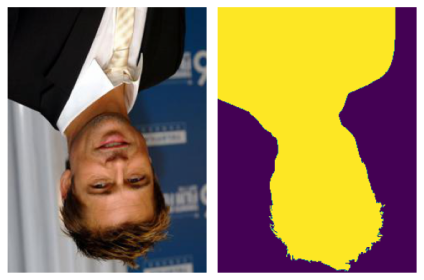

In [55]:
show_idx_image(new_train_dataset, 780)

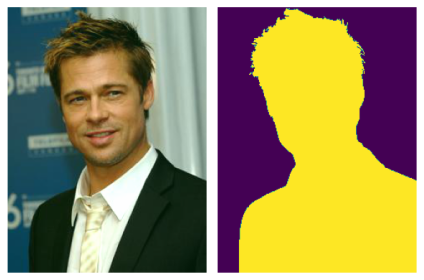

In [63]:
show_idx_image(new_train_dataset, 780)

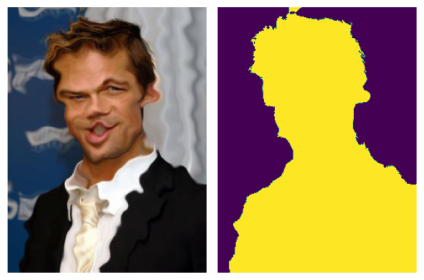

In [74]:
show_idx_image(new_train_dataset, 780)

In [75]:
num_epoch = 20
lr = 1e-4
weight_decay = 1e-4

model = UNet(num_classes=1, num_blocks=4)

activation = {}
criterion = DiceLoss(reduction='mean')
iou_score = IoUScore(0, reduction='mean')
dice_score = DiceLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train(model, device, criterion, iou_score, dice_score, num_epoch, train_data_loader, test_data_loader, train_dataset, test_dataset, 'weights_cross', True, True, True, True, True, True)

In [67]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs --port=6

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Действительно, применение аугментации дало самый лучший результат! (значение лосса на тесте после 20 эпох 0.0051)

## `Бонус: torch.compile (0.25 балла)`

Попробуйте установить [Pytorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) и запустите обучение с использованием `torch.compile`. Тщательно сравните время с и без использованием компиляции.

*Замечание:* обязательно укажите конфигурацию системы (версия OS, модель CPU/GPU, объём RAM), на которой производилось обучение. В частности, приложите вывод команд:
```bash
! nvcc --version
! nvidia-smi
```